# Grid cell model 

Code Structure is the following:

- Define the grid cell coordinates (n^2 x 2) (x and y)
- Define the 1 dim distance between 2 set of coordinates of neurons
- Define the a new grid with the preference direction
- Define the recurrent connectivity profile using the distance calculated before
- Defineand solve the differential equation defining the dynamics of the system for a number of time steps
- Plotting the result

In [2]:
# grid cell model 
#phase offset detector:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Create a grid, so coordinates for the 2D neural sheet. with 2 matrices y_:[[0 0 ... 0],[1 1 ... 1],..,[n, n, n, ..., n] and x_:[[0 1 2 ... n],.., [0 1 2 ... n]] all possible combinations of coordinates are given. Concatenating each matrix results in the  vectors x and y.

In [3]:
n= 40
x = np.indices((n,n))
y_c = np.concatenate(x[0])
x_c = np.concatenate(x[1])
#print(type(x_c))

If we want to calculate the distance of each neuron (there are n^2) to each other neuron (also n^2) so in total a matrix for all distances has the size (n^2 x n^2). (if we want the distance of one fix neuron to all neurons the matrix has size n^2.)
So subtracting all x coordinates from one fix coordinate value results in a matrix of distances. (neurons in the same column have x distance zero.)

Now repeating the vector x (size n^2)  n^2 times enables us to subtract from it its transposed, which results in the pairwise x distance by design.

In [4]:
x_ = np.tile(x_c, (n**2,1))
xdist = np.abs(x_-x_.T)
#print(xdist)

Plot of x distance for the first neuron.

In [5]:
#plt.imshow(xdist[0:39, 0:39])#, cmap='gray')

why do I need to compute the distance between each neuron? For the phase offset detector and because of the directional preference of the neurons leading to a shift of the position in the connectivity profile.

We can do the same for the y_ distance. The plot looks the same as fo the x_distance but with the great difference that it is for all the neurons!

In [6]:
y_ = np.tile(y_c, (n**2,1))
ydist = np.abs(y_-y_.T)
#print(ydist)
#plt.imshow(ydist)

If we do the same for the y direction and calculate the eucledian distance the result is:

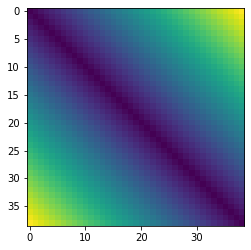

In [7]:
#y_ = np.tile(y_c, (n**2,1))
dist = np.sqrt(xdist**2+ydist**2)
#print(dist.shape)
plt.imshow(dist[0:39,0:39])# [1560:1599,0:39])# [0:39, 0:39])#, cmap='gray')

So we calculated a distance matrix of neurons to each other with. in addition we connect edges of opposite sides.

In [8]:
#compute distance between 2 coordinates, 
#a and b are 2 vectors of 2 grids (n^2 x 1) coordinates.
def comp_dist(a, b):
    na = int(np.sqrt(len(a)))
    nb = int(np.sqrt(len(b)))
    #print((a))
    a_ = np.tile(a, (nb**2,1))
    b_ = np.tile(b, (na**2,1))
    
    dist1 = np.abs(a_-b_.T)
    dist2 = n - dist1
    return np.minimum(dist1, dist2)

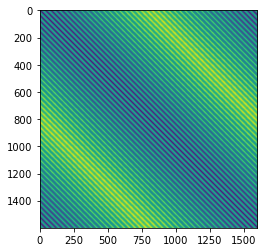

In [9]:
xdist = comp_dist(x_c,x_c)
ydist = comp_dist(y_c,y_c)
dist_f = np.sqrt(xdist**2+ydist**2)
plt.imshow(dist_f)

Now we define 4 prefered directions of neurons and add directional preference to the neurons. For this we first create an index z that tells which neuron has which preference direction [1, 2, 3, 4]. Then we create a matrix selecting the vectors from the array directions.

In [10]:
directions = [[1,0],[0,1],[-1,0],[0,-1]]#  E N W S
z = 2 * (y_c % 2) + x_c % 2

g = np.take(directions, z, axis=0)# g is an array with the vector of directional preference for each neuron
#print(g.shape)
#print(g[:, 0].shape)
x_s = x_c - g[:, 0]# subtract to each neuron position the vector of directional preference.
y_s = y_c - g[:, 1]

Now we compute the distance of the each neuron to each other taking into account the shift.

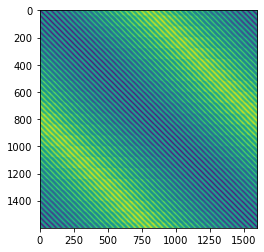

In [11]:
xdist = comp_dist(x_c,x_s)
ydist = comp_dist(y_c,y_s)
dist_f = np.sqrt(xdist**2+ydist**2)
plt.imshow(dist_f)

Finally we calculate the recurretn weights with rec(d) = e^(−γd^2)− e^(−βd^2)

In [12]:
def rec(d):
    llambda = 15
    beta = 3 /(llambda**2)
    gamma = 1.05*beta
    w = np.exp(-gamma*d**2)-np.exp(-beta*d**2)
    return w

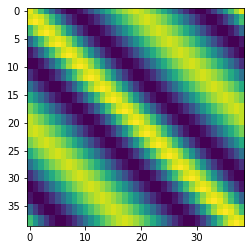

In [13]:
w_rec = rec(dist_f)
plt.imshow(w_rec[0:39, 0 :39])

Now we calculate the recurrent weights

In [14]:
# def dynamics(B, s, w, tau, dt):
    
#     q = np.dot(s,w) + B
    
#     s_ = np.zeros_like(s)
    
#     s_[q<0] = s[q<0] / (1 + tau/dt )
    
#     s_ = np.linalg.lstsq((tau/dt+1)*np.eye(len(s))-w, tau/dt*s+B)
#     s_[q>0] = s__[0][q>0]
        
#     return s__

def dynamics(b, s0, w, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    
    f = np.maximum(0, np.tensordot(s0, w, axes=1) + b)
    s = (s0 + f * dt / tau) / (1 + dt / tau)
    return s

Intitialize the spiking

In [15]:
def calculate_B(v):
    g_m = 0.7
    alpha = 0.10315
    tau = 1e-1
    dt = 1e-2
    #print(g)
    #print(v)
    B = 1 + g_m * alpha * np.tensordot(g, v, axes=1)
    return B

start simulation

In [16]:
nr_steps =300

In [17]:
s = np.random.rand(n**2)*10**(-2)
tau = 1e-1
dt = 1e-2
for i in range(nr_steps):
    v = np.random.rand(2)*0.2
    B = calculate_B(v)
    s = dynamics(B, s, w_rec, tau, dt)
s0 = s

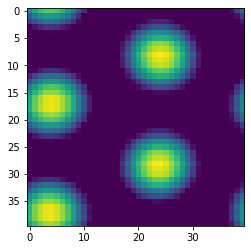

In [18]:
s_resh = np.reshape(s, (40,40))
plt.imshow(s_resh)

Try to add a velocity vector v= (10,10) for 100 steps.


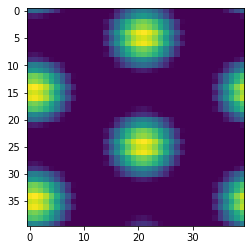

In [19]:
V= np.array([1.5, 1.5])*0.2
nr_steps_shift =1000
fig = plt.figure()
for i in range(nr_steps_shift):
    B = calculate_B(V)
    s = dynamics(B, s, w_rec, tau, dt)

plt.imshow(np.reshape(s, (40,40)))
t = s


#s0 = s
# 
# def updatefig(i):
#     #fig.clear()
#     s = s0
#     #print (s.shape)
#     B = calculate_B(V)
#     #print(B.shape, s.shape)
#     s_ = dynamics(B, s, w_rec, tau, dt)
#     s = s_
#     p = plt.imshow(np.reshape(s_, (40,40)))

In [ ]:
#plt.imshow(np.reshape(s, (40,40)))

# fig = plt.figure()

# def updatefig(i):
#     fig.clear()
#     p = plt.imshow(np.reshape(s, (40,40)))
#     #plt.draw()
    
# anim = animation.FuncAnimation(fig, updatefig, frames=2000, interval=nr_steps_shift) #, 10)
# writergif = animation.PillowWriter(fps=30)
# plt.show()
# anim.save('test2.gif',writer=writergif)

# Phase offset detector

Define a decoder phase offset detector. Goal is to get the difference between 2 activation vectors.
- receive a vector s and a vector t ( activity at current and goal location)
- define a grid of phase offset detectors and their preference direction.
- calculate the activation value of the phase offset detector. p_j = f(s*w_in+t*w_out) with defined connectivity profiles.
- 

Define how the reccurretn connections are defined. 
First a connection from one activity pattern s to the phase offset detector is defined. w_in. so from the location x_j of a POD to that of a neuron. and this for all neurons and all POD.
Therby their distance must be calculated.

In [133]:
def in_(d):
    eta = 0.25
    print(d.shape)
    beta = 3/ 15**2
    weight_in = eta * ( np.exp(-beta * d**2) - 1 )
    print(weight_in.shape)
    return weight_in

def ex_(d):
    beta = 3 / 15**2
    weight_ex = np.exp(-beta*d**2)
    return weight_ex


Define the grid of phase offset detectors

In [134]:
n_pod = 10
num_dir = 16
theta_pod = np.linspace(0, 2*np.pi, num_dir+1)
theta_pod = theta_pod[0:num_dir]
print(theta_pod)
x_pod = np.indices((n_pod,n_pod))*n/n_pod
y_c_pod = np.concatenate(x_pod[0]) 
x_c_pod = np.concatenate(x_pod[1])

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265 3.53429174 3.92699082 4.3196899
 4.71238898 5.10508806 5.49778714 5.89048623]


Compute distance and connectivity.

(1600, 100)
(1600, 100)
(1600, 100)


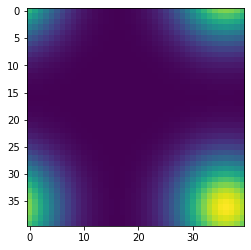

In [140]:
xd = comp_dist(x_c_pod, x_c)
yd = comp_dist(y_c_pod, y_c)
d = np.sqrt(xd**2+yd**2)
w_in = in_(d)
print(w_in.shape)
plt.imshow(np.reshape(w_in[:,99],(40,40)))

Now we come to the connection of the goal activity to the phase offset detector. First define w_ex for each angle. There are N_pod x N_pod x num_dir phase offset detectors.

in contrast to Tim's code i took 16 angles, such that the last and the first are different. Because 0° and 360° represent the same direction.

(1600, 100)


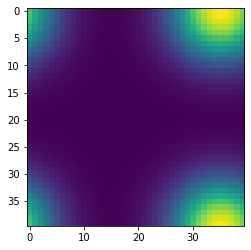

In [144]:
delta = 5 # for the value 7 i don't get an response from th ephase offset detector for this example shift
w_ex = np.zeros((n**2, n_pod**2, num_dir))
for i, angle in enumerate(theta_pod):
    #print(angle)
    y_c_pod_t = np.concatenate(x[0]) + delta * np.sin(angle)
    x_c_pod_t = np.concatenate(x[1]) + delta * np.cos(angle)
    xd = comp_dist(x_c_pod, x_c_pod_t)
    yd = comp_dist(y_c_pod, y_c_pod_t)
    d = np.sqrt(xd**2+yd**2)
    #print(ex_(d).shape)
    w_ex[:, :, i] = ex_(d)
print(w_ex[:,:,0].shape)
plt.imshow(np.reshape(w_ex[:,0,0],(40,40)))

Now we have the recurrent correctivity profiles for the phase offset detector. So we calculate the phase offset.\\
p_j for each angle has the shape (100) with 16 angle p has the shape (100,16) and it contains the information aboout the response of the phase offset detector along a direction.

(1600, 100, 16)


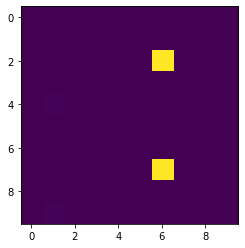

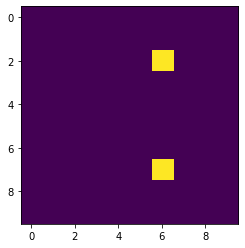

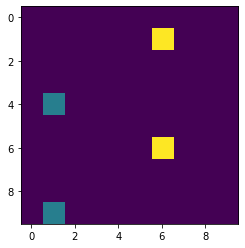

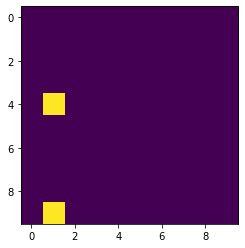

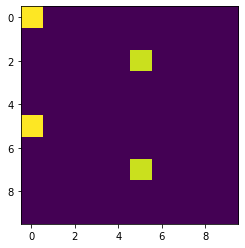

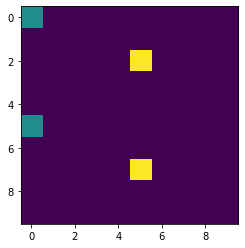

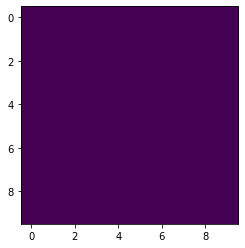

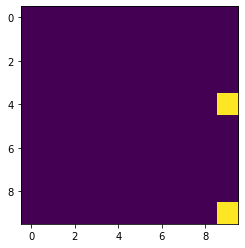

In [145]:
print(w_ex.shape)
#plt.imshow(w_ex)
p = np.zeros((n_pod**2, num_dir))
#print(p.shape)
for i, angle in enumerate(theta_pod):
    p[:, i] = np.maximum(0, np.dot(s, w_in)+ np.dot(t, w_ex[:,:, i]))
    #print(p.shape)
#plt.imshow(np.reshape(p, (10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 2],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 3],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 0],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 1],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 4],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 5],(10,10)))
fig2 = plt.figure()
plt.imshow(np.reshape(p[:, 6],(10,10)))
fig1= plt.figure()
plt.imshow(np.reshape(p[:, 7],(10,10)))

# Motor neurons output
In the next steps the phase offsets in the same directions are aggregated. As hre there is only one module its just a simple sum.

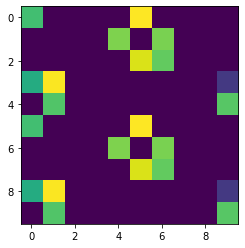

In [146]:
plt.imshow(np.reshape(np.sum(p, axis=1),(10,10)))
#print(p.shape)
p_ = np.sum(p, axis = 0)
##print(p_.shape)
#plt.imshow(np.reshape(p_, (10,10)))
#print(p_)

In [147]:
#print(np.in1d(p[:, 0],p[:, 3]))

#  final motor-output signal

In [148]:
Theta = np.array([0.0, 0.0])
for i, angle in enumerate(theta_pod):
    Theta += p_[i] * np.array([np.cos(angle), np.sin(angle)])
    
Theta_ = 1/(n_pod**2*num_dir) * Theta

In [149]:
print(Theta)

[ 1.07314706 -0.07653894]


In [120]:
A = np.array([1,2,3,4])
print(A)
B = np.array([[1,2,3,4],[11,22,33,40], [1,0,1,1], [0,2,2,0],])
print(B)
C= A*B
print(C)
D = np.dot(A,B)
print(D)
E = np.tensordot(A, B, axes=1) 
print(E)

[1 2 3 4]
[[ 1  2  3  4]
 [11 22 33 40]
 [ 1  0  1  1]
 [ 0  2  2  0]]
[[  1   4   9  16]
 [ 11  44  99 160]
 [  1   0   3   4]
 [  0   4   6   0]]
[26 54 80 87]
[26 54 80 87]
